This notebook is designed to show how to use the cratrcountr package to do Bayesian crater age calculations for the Moon using multiplication of full Poisson PDFs.

Here, we load the necessary packages

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma,poisson,linregress,beta,norm,lognorm
from scipy import optimize
import time
import random
import pickle as pkl
from cratrcountr import *
%matplotlib inline

For our example data, we will use the counts of the Apollo 15 landing site from Robbins et al. (2014) provided by Stuart Robbins.  They come from LROC NAC image M146959973L.  The diameters are in units of pixels, and an adjustment is made for pixel size.  The area is an estimated area of the image.  It is not properly buffered, and it does not represent a clearly identified geologic unit per se.  These values are uncertain and could be wrong.  These data are for example purposes only.

In [2]:
cfactor=np.cos(math.pi*(26 + 11/60)/180)*0.626608880720610
rawd = pd.read_csv('M146959973L.txt',delimiter='\t')*cfactor
ds = np.array(sorted(rawd['D_wm'].tolist()))/1000
area = 4000*2215*cfactor**2/1000000

Let's start by plotting these data on a cumulative unbinned plot.  From this plot, we can tell that there is an equilibrium saturation inflection point at around ~0.09km.  In order to calculate ages, we have to exclude saturated portions of the curve.  To safely exclude saturated data, we will be excluding all craters below 0.1km.

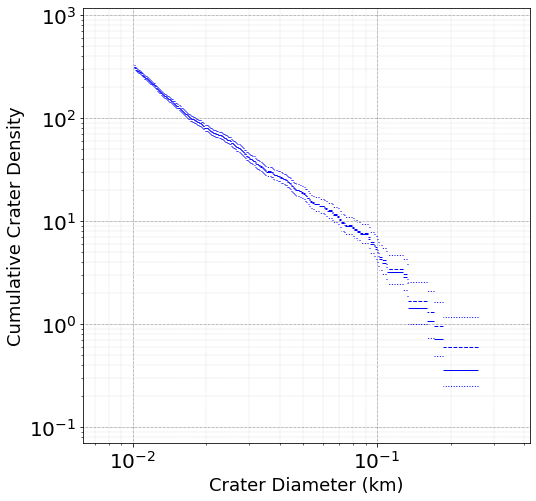

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_cumulative_unbinned(ds,area,color='blue',random_sigma=0,ax=ax)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_cumulative_unbinned.pdf',bbox_inches='tight')

We can also plot a cumulative plot that assumes a 10% random error in diameter measurement.  This produces a smoothed curve that also shows an equilibrium saturation inflection point at ~0.09km.  Even with the random error, we do not see a slope deviation by 0.1km, adding confidence that a saturation cutoff at 0.1km will be safe for use in age calculations.

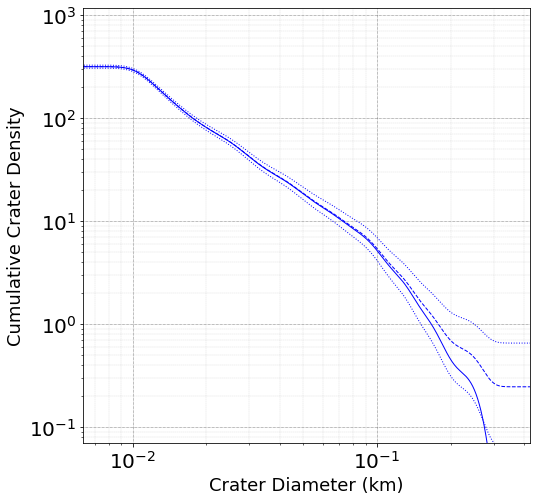

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_cumulative_unbinned(ds,area,color='blue',random_sigma=0.1,ax=ax)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_cumulative_unbinned_random_error.pdf',bbox_inches='tight')

Now, we will set the saturation_cutoff variable at 0.1km.

In [8]:
saturation_cutoff=0.1

In order to actually do the age calculations, we will use an incremental plot.  There are several advantages of the incremental plot.  Unlike the cumulative plot, each bin is independent from each other, dramatically simplifying the statistics.  Unlike the differential and R plots, the incremental plot does not require an adjustment that depends on the production function.  The incremental plot is also, in many ways, the simplest and clearest to understand.  It simply shows the number of craters in each bin.  Here, we choose a bin width exponent of 0.25, setting our reference point to 0.1km, so our bin edges follow the series 0.1*2^(0.25n).  This reference point is set here so that we can exclude all data below 0.1km in order to avoid equilibrium saturation effects.  (NOTE: These data are in the diameter range where quasi-equilibrium effects are negligible, D<5km.  When in the quasi-equilibrium domain, this simple diameter range exclusion approach will not be sufficient to address saturation.)  One of the bins does not show the filled circle that indicates the maximum likelihood value because it is a bin with no craters in it, and for zero-crater bins, the maximum likelihood value is zero, which plots at negative infinity on a log-log plot.  Under Poisson statistics, a zero-crater bin still provides chronology information, and it cannot be ignored.  In fact, as we will soon see, we will have to incorporate the information we gain from having no craters larger than our largest bin.  However, if we were plotting with only zero-crater bins, we would have to be extremely careful about priors.

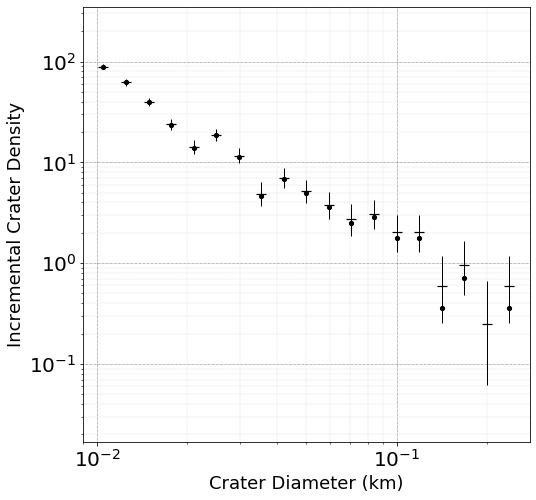

In [241]:
bin_width_exponent=0.25

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_incremental(ds,area,bin_width_exponent=bin_width_exponent,reference_point=saturation_cutoff,ax=ax)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_incremental.pdf',bbox_inches='tight')

At this point, we're ready to calculate the age distribution using the one-line function.

Run time: 0.05821s


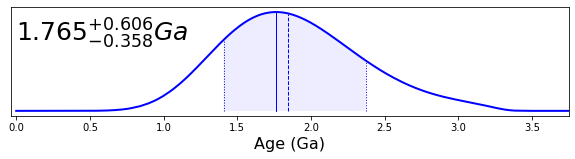

In [623]:
t1=time.time()
plot_age(ds, area, bin_width_exponent=bin_width_exponent, saturation_cutoff=saturation_cutoff,random_sigma=0)
t2=time.time()
print('Run time: ' + str(round(t2-t1,5)) + 's')
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_final_age.pdf',bbox_inches='tight')

To explain in more detail how this works, let's work through the process step by step.  In the next step, we calculate the underlying data from the incremental left plot.  This takes a bit longer than the plotting does because we produce numerical distributions with 100,000 points each for each bin.  The number of points in the numerical distributions can be adjusted for computational accuracy and speed.  On a rather old MacBook Pro, it takes a bit under 2 seconds to run.

In [243]:
t1=time.time()
binned_data = calc_incremental(ds,area,n_points=2000,bin_width_exponent=bin_width_exponent,\
                                    reference_point=saturation_cutoff)
t2=time.time()
print('Done in: ' + str(round(t2-t1,5)) + ' s')

Done in: 0.0527 s


To visualize this calculation, we plot the PDFs of the cratering rate parameter, λ, in terms of craters per bin.  What λ describes is the likelihood distribution of different possible underlying cratering rates given the actual number of craters observed.  The shapes of these PDFs follow the percent-point function of the gamma distribution (a continuous extrapolation of the Poisson distribution).

We will only use bins above the saturation cutoff in the age analysis.  In the left-hand plot, we show the PDFs for all the bins, with the bins above the saturation cutoff in black and the others in gray.  In the right-hand plot, we zoom in on the bins above the saturation cutoff--the bins we will use for age analysis.

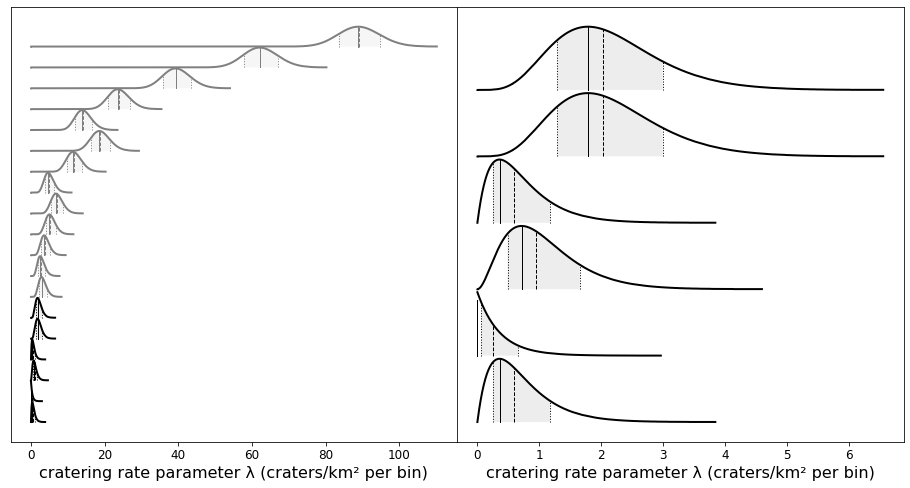

In [254]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(121)
num_bins_fitted=binned_data[binned_data['D']>=saturation_cutoff].shape[0]
color_list=['gray']*(binned_data.shape[0]-num_bins_fitted)+['black']*num_bins_fitted
for i in list(range(binned_data.shape[0])):
    plot_pdf(binned_data.iloc[i]['density_pdf'],binned_data.iloc[i]['P_pdf'],upshift=-1.05*i,ax=ax,\
             color=color_list[i])
plt.yticks([])
plt.xticks(size=12)
plt.xlabel('cratering rate parameter λ (craters/km\N{SUPERSCRIPT TWO} per bin)',size=16)
ax=fig.add_subplot(122)
color_list=['gray']*(binned_data.shape[0]-num_bins_fitted)+['black']*num_bins_fitted
for i in list(range(binned_data.shape[0]-num_bins_fitted,binned_data.shape[0])):
    plot_pdf(binned_data.iloc[i]['density_pdf'],binned_data.iloc[i]['P_pdf'],upshift=-1.05*i,ax=ax,\
             color=color_list[i])
plt.yticks([])
plt.xticks(size=12)
plt.xlabel('cratering rate parameter λ (craters/km\N{SUPERSCRIPT TWO} per bin)',size=16)
plt.subplots_adjust(wspace=0, hspace=0)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_lambda.pdf',bbox_inches='tight')

Next, we calculate the distribution of different N(D=1km) projected cumulative count values for each bin, using the "new" Neukum Production Function as the assumed production function.  The reason we convert to N(1) counts is that the Neukum Chronology Function uses N(1) counts as its input.  We also have to convert to N(1) counts so that we can incorporate the information from the absense of craters larger than the largest bin.  This absence of craters must be compared against the cumulative, not the incremental left, version of the production function.

WARNING: This step assumes no shape uncertainty whatsoever in the Neukum Production Function.  This is a standard assumption, but in real life there is almost certainly some shape uncertainty in the Neukum Production Function.  Exactly how large this effect is is unknown.

In [245]:
binned_data = binned_data.assign(n1_pdf=((binned_data['density_pdf']/(binned_data['D'].\
                apply(lambda d: npf_new_incremental(d,bin_width_exponent=bin_width_exponent))))*npf_new(1)))

Here, we visualize the calculated projected N(1) values.

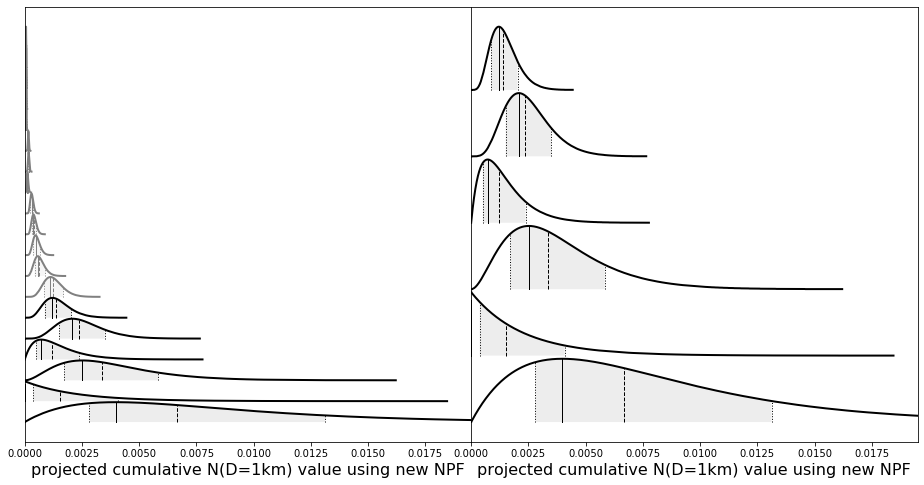

In [246]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(121)
color_list=['gray']*(binned_data.shape[0]-num_bins_fitted)+['black']*num_bins_fitted
for i in list(range(binned_data.shape[0])):
    plot_pdf(binned_data.iloc[i]['n1_pdf'],binned_data.iloc[i]['P_pdf'],upshift=-1.05*i,ax=ax,color=color_list[i])
plt.xlim([0,0.0195])
plt.yticks([])
#plt.xticks(size=20)
plt.xlabel('projected cumulative N(D=1km) value using new NPF',size=16)
ax=fig.add_subplot(122)
color_list=['gray']*(binned_data.shape[0]-num_bins_fitted)+['black']*num_bins_fitted
for i in list(range(binned_data.shape[0] - num_bins_fitted,binned_data.shape[0])):
    plot_pdf(binned_data.iloc[i]['n1_pdf'],binned_data.iloc[i]['P_pdf'],upshift=-1.05*i,ax=ax,color=color_list[i])
plt.xlim([0,0.0195])
plt.yticks([])
#plt.xticks(size=20)
plt.xlabel('projected cumulative N(D=1km) value using new NPF',size=16)
plt.subplots_adjust(wspace=0, hspace=0)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_N1.pdf',bbox_inches='tight')

Next, we calculate the N(1) distribution associated with the observation of zero craters larger than the maximum diameter of our largest bin.  Because this is a cumulative observation of no craters larger than a certain diameter, we project this distribution to N(1) using the cumulative version of the "new" Neukum Production Function, not the incrememntal left version.  We first calculate the numerical distribution then the PDF.  Here we also calculate X_pdf, the values of N(1) corresponding to the relative probabilities.  The X_pdf must be the same for each PDF in order to multiply the PDFs together.

In [251]:
X_pdf_raw,zero_pdf=igpdf(0,n_points=5*n_points)
X_pdf=X_pdf_raw/area/npf_new(binned_data.iloc[-1]['D']*2**bin_width_exponent)*npf_new(1)

Next, we normalize all the N(1) PDFs from the bins to X_pdf.

In [255]:
n1_pdf_list=[np.interp(X_pdf,row['n1_pdf'],row['P_pdf']) for i,row in binned_data[-1*num_bins_fitted:].iterrows()]

Then, we multiply these PDFs together to produce a posterior PDF showing the distribution of possible N(1) values.

In [256]:
Y_combined_pdf = np.prod(n1_pdf_list,axis=0)*zero_pdf

Here, we visualize the multiplication of the N(1) distributions for each data bin used (black) together with the N(1) distribution for the absence of craters larger than the largest bin (gray).  In blue we have the final PDF.  Note how the specific shapes of these PDFs matter, leading to a quite different result than would be reached by just averaging the median values.

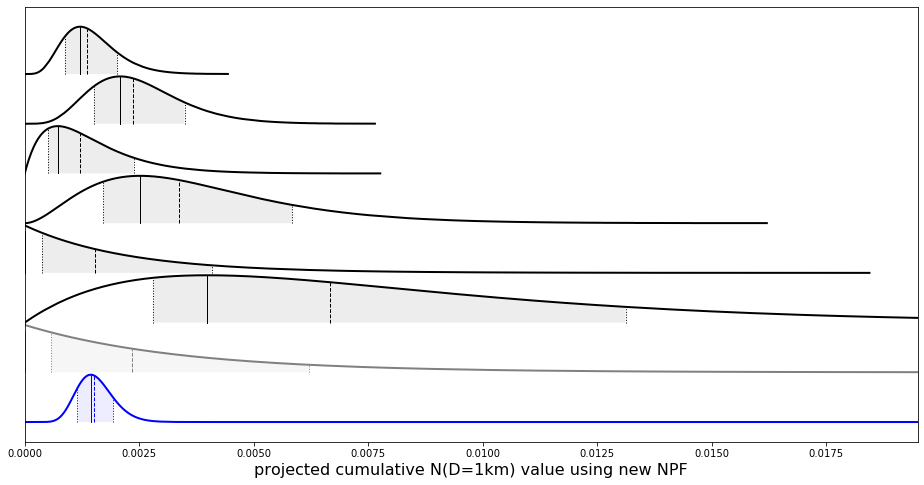

In [257]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
for i in list(range(binned_data.shape[0] - num_bins_fitted,binned_data.shape[0])):
    plot_pdf(binned_data.iloc[i]['n1_pdf'],binned_data.iloc[i]['P_pdf'],upshift=-1.05*i,ax=ax,\
             color='black')
plot_pdf(X_pdf,zero_pdf,upshift=-1.05*binned_data.shape[0],ax=ax,color='gray')
plot_pdf(X_pdf,Y_combined_pdf,ax=ax,upshift=-1.05*(binned_data.shape[0]+1))
plt.xlim([0,0.0195])
plt.yticks([])
#plt.xticks(size=20)
plt.xlabel('projected cumulative N(D=1km) value using new NPF',size=16)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_multiplication.pdf',bbox_inches='tight')

This is a combined figure showing both the N1 and the λ plots.

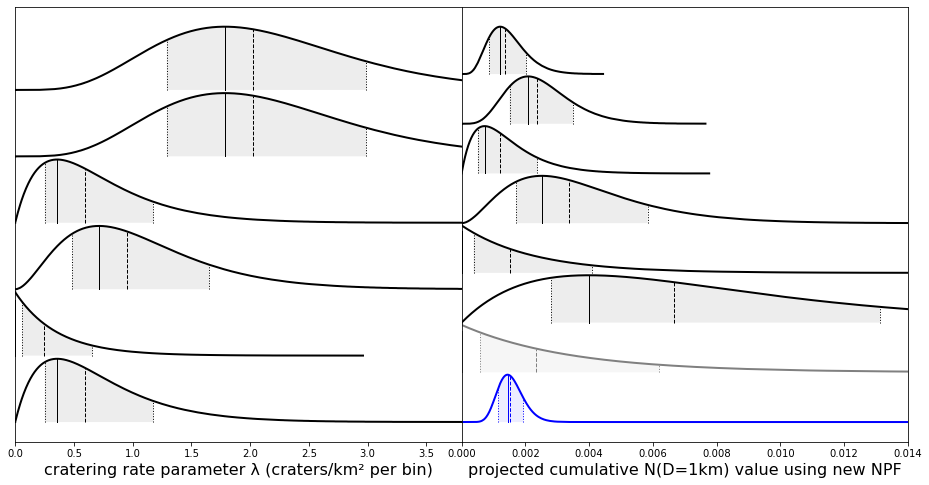

In [258]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(121)
color_list=['gray']*(binned_data.shape[0]-num_bins_fitted)+['black']*num_bins_fitted
for i in list(range(binned_data.shape[0] - num_bins_fitted,binned_data.shape[0])):
    plot_pdf(binned_data.iloc[i]['density_pdf'],binned_data.iloc[i]['P_pdf'],upshift=-1.05*i,ax=ax,\
             color=color_list[i])
plt.xlim([0,3.8])
plt.yticks([])
#plt.xticks(size=20)
plt.xlabel('cratering rate parameter λ (craters/km\N{SUPERSCRIPT TWO} per bin)',size=16)
ax=fig.add_subplot(122)
for i in list(range(binned_data.shape[0] - num_bins_fitted,binned_data.shape[0])):
    plot_pdf(binned_data.iloc[i]['n1_pdf'],binned_data.iloc[i]['P_pdf'],upshift=-1.05*i,ax=ax,\
             color='black')
plot_pdf(X_pdf,zero_pdf,upshift=-1.05*binned_data.shape[0],ax=ax,color='gray')
plot_pdf(X_pdf,Y_combined_pdf,ax=ax,upshift=-1.05*(binned_data.shape[0]+1))
plt.xlim([0,0.014])
plt.yticks([])
#plt.xticks(size=20)
plt.xlabel('projected cumulative N(D=1km) value using new NPF',size=16)
plt.subplots_adjust(wspace=0, hspace=0)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_combined_fig.pdf',bbox_inches='tight')

A visualization of just the final N(1) distribution.

(0.001148552505334907,
 0.0015086743149366213,
 0.00193726574817691,
 0.0014428637658807132)

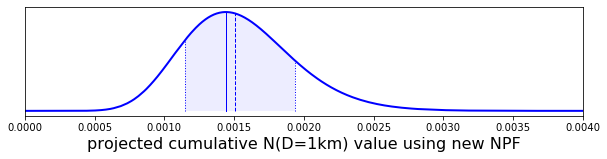

In [284]:
low,med,high,max_val=plot_pdf(X_pdf,Y_combined_pdf)
plt.yticks([])
plt.xlim([0,0.004])
plt.xlabel('projected cumulative N(D=1km) value using new NPF',size=16)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_N1_dist.pdf',bbox_inches='tight')
low,med,high,max_val

To calculate the final age distribution, we sample the PDF into a numerical distribution, run it through the inverse of the Neukum Chronology Function (ncf_inv), then convert it back to a PDF.

Mathematically, here is how this works on a more detailed level:  First, we apply ncf_inv to X_pdf.  Next, we have to adjust Y_combined_pdf for the fact that X_pdf no longer has uniformed spacing.  To calculate this adjustment, we calculate the derivative (or gradient) between ncf_inv(X_pdf) and X_pdf.  Then, we apply the adjustment.  Finally, we interpolate this adjusted PDF onto a linear array in time space with equally spaced points in it, creating a final age PDF with equally spaced points.

In [264]:
T_pdf=np.linspace(ncf_inv(X_pdf.min()),ncf_inv(X_pdf.max()),5*n_points)
P_pdf=np.interp(T_pdf,ncf_inv(X_pdf),np.gradient(X_pdf,ncf_inv(X_pdf))*Y_combined_pdf)

Finally, we show the age distribution, along with the true age from Stöffler and Ryder (2001).

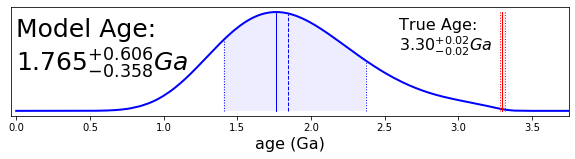

In [271]:
low,med,high,max_val=plot_pdf(T_pdf,P_pdf)
plt.xlabel('age (Ga)',size=16)
plt.yticks([])
val999 = np.percentile(P_pdf.cumsum(),99.9)
idx=np.argmin(abs(P_pdf.cumsum()-val999))
age_max = T_pdf[idx]
plt.fill_between([3.28,3.32],0,1, facecolor='r', alpha=0.07)
plt.plot([3.28,3.28],[0,1],'r:')
plt.plot([3.30,3.30],[0,1],'r')
plt.plot([3.32,3.32],[0,1],'r:')
plt.xlim([-0.01*age_max,age_max])
plt.text(0,0.4,r'$'+str(round(max_val,3))+'_{-'+str(round(max_val-low,3))+'}^{+'+str(round(high-max_val,3))\
         +'}Ga$',size=25)
plt.text(0,0.75,r'Model Age:',size=25)
plt.text(2.6,0.6,r'$3.30_{-0.02}^{+0.02}Ga$',size=16)
plt.text(2.6,0.82,r'True Age:',size=16)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_AgeModel.pdf',bbox_inches='tight')

This is a comprehensive figure showing the process of creating a combined N(1) PDF.  It also compares the results to other N(1) values measured for the Apollo 15 site at other portions of the cratering curve.

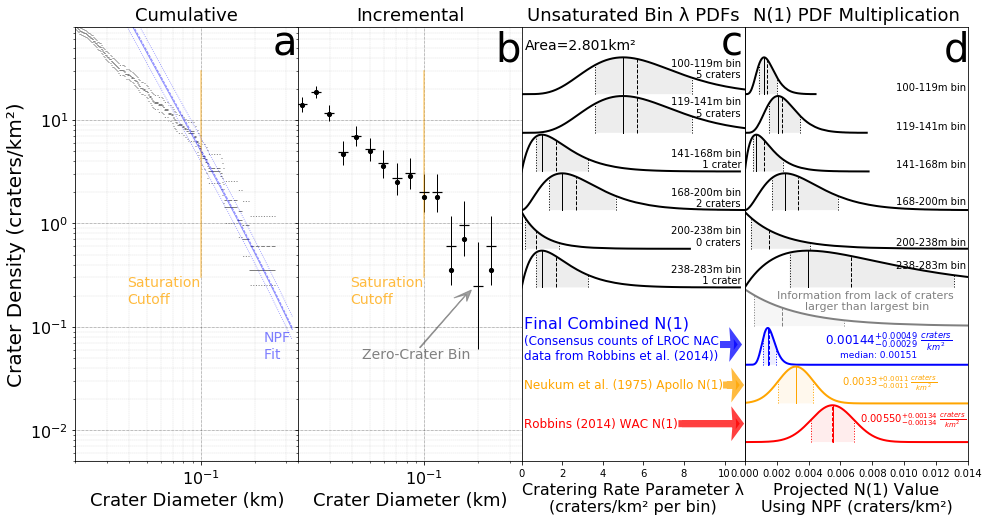

In [328]:
fig = plt.figure(figsize=(16,8))

ax=fig.add_subplot(144)
for i in list(range(binned_data.shape[0] - num_bins_fitted,binned_data.shape[0])):
    plot_pdf(binned_data.iloc[i]['n1_pdf'],binned_data.iloc[i]['P_pdf'],upshift=-1.05*i,ax=ax,color='black')
    if i==binned_data.shape[0] - 1:
        bumpup=0.43
    elif i==binned_data.shape[0] - 3:
        bumpup=0.05
    else:
        bumpup=0
    plt.text(0.0095,bumpup+0.1-1.05*i,str(int(1000*round(binned_data['D'][i],3))) + '-' + \
             str(int(1000*round(binned_data['D'][i]*2**bin_width_exponent,3))) + 'm bin', size=10)
plot_pdf(X_pdf,zero_pdf,upshift=-1.05*binned_data.shape[0],ax=ax,color='gray')
n1_low,n1_med,n1_high,n1_max=plot_pdf(X_pdf,Y_combined_pdf,ax=ax,upshift=-1.05*(binned_data.shape[0]+1))
plot_pdf(X_pdf,norm.pdf(X_pdf,loc=0.0032,scale=0.0011),color='orange',ax=ax,upshift=-1.05*(binned_data.shape[0]+2))
plot_pdf(X_pdf,norm.pdf(X_pdf,loc=0.0055,scale=0.00134),color='red',ax=ax,upshift=-1.05*(binned_data.shape[0]+3))
xmin,xmax=0,0.014
ymin,ymax=-1.05*(binned_data.shape[0]+3.5),-1.05*(binned_data.shape[0]-num_bins_fitted-1.75)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.yticks([])
plt.title('N(1) PDF Multiplication',size=18)
#plt.xticks(size=20)
plt.xlabel('Projected N(1) Value\nUsing NPF (craters/km\N{SUPERSCRIPT TWO})',size=16)
plt.text(0.002,-19.5,'Information from lack of craters\n        larger than largest bin',color='gray',size=11)
plt.text(0.005,-20.45,r'$'+str(round(n1_max,5))+\
         '_{-'+str(round(n1_max-n1_low,5))+'}^{+'+\
         str(round(n1_high-n1_max,5))+'}$'+r' $\frac{craters}{km^2}$',size=12, color='blue')
plt.text(0.006,-20.8,r'median: ' + str(round(n1_med,5)),size=9, color='blue')
plt.text(0.0061,-21.55,r'$'+'0.0033'+\
         '_{-'+'0.0011'+'}^{+'+\
         '0.0011'+'}$'+r' $\frac{craters}{km^2}$',size=10, color='orange')
plt.text(0.0072,-22.55,r'$'+'0.00550'+\
         '_{-'+'0.00134'+'}^{+'+\
         '0.00134'+'}$'+r' $\frac{craters}{km^2}$',size=10, color='red')
ax.text(xmin+0.89*(xmax-xmin), ymin+0.92*(ymax-ymin), 'd', size=40)

ax=fig.add_subplot(141)
rand_array=np.arange(-1.7,-0.48,0.01)
plt.plot([saturation_cutoff,saturation_cutoff],[0.3,30],'-',color='orange',linewidth=1.5,alpha=0.5)
plt.plot(10**rand_array,n1_max/ncf(1)*npf_new(10**rand_array),'b',alpha=0.5,linewidth=0.8)
plt.plot(10**rand_array,n1_med/ncf(1)*npf_new(10**rand_array),'b--',alpha=0.5,linewidth=0.8)
plt.plot(10**rand_array,n1_low/ncf(1)*npf_new(10**rand_array),'b:',alpha=0.5,linewidth=0.8)
plt.plot(10**rand_array,n1_high/ncf(1)*npf_new(10**rand_array),'b:',alpha=0.5,linewidth=0.8)
# plt.plot(10**rand_array,equilibrium_saturation(10**rand_array))
# plt.plot(10**rand_array,0.05*equilibrium_saturation(10**rand_array))
# plt.plot(10**rand_array,hartmann_equilibrium(10**rand_array))
plot_cumulative_unbinned(ds,area,ax=ax)
nac_n1 = 0.00172
plt.text(0.039,0.17,'Saturation\nCutoff',color='orange',size=14,alpha=0.75)
plt.text(0.225,0.05,'NPF\nFit',color='blue',size=14, alpha=0.5)
plt.ylim([0.005,80])
plt.xlim([0.02,0.35])
plt.ylabel('Crater Density (craters/km\N{SUPERSCRIPT TWO})',size=20)
plt.title('Cumulative',size=18)
plt.xticks(size=16)
plt.yticks(size=16)
ax.text(0.25, 43, 'a', size=40)

ax=fig.add_subplot(142)
plt.plot([saturation_cutoff,saturation_cutoff],[0.3,30],'-',color='orange',linewidth=1.5,alpha=0.5)
plot_incremental(ds,area,bin_width_exponent=bin_width_exponent,reference_point=saturation_cutoff,ax=ax)
plt.text(0.039,0.17,'Saturation\nCutoff',color='orange',size=14,alpha=0.75)
plt.ylabel(None)
plt.title('Incremental',size=18)
plt.xticks(size=16)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
plt.ylim([0.005,80])
plt.xlim([0.02,0.35])
ax.text(0.25, 37, 'b', size=40)
plt.text(0.045,0.05,'Zero-Crater Bin',color='gray',size=14)
plt.arrow(0.095,0.063,0.065,0.12,color='gray',head_width=0.03,head_length=0.05,overhang=0.5,alpha=0.75)

ax=fig.add_subplot(143)
color_list=['gray']*(binned_data.shape[0]-num_bins_fitted)+['black']*num_bins_fitted
for i in list(range(binned_data.shape[0] - num_bins_fitted,binned_data.shape[0])):
    plot_pdf(binned_data.iloc[i]['λ_pdf'],binned_data.iloc[i]['P_pdf'],upshift=-1.05*i,ax=ax,color=color_list[i])
    if (i==binned_data.shape[0] - num_bins_fitted) or (i==binned_data.shape[0] - num_bins_fitted + 1):
        bumpup=0.35
        spacer2=''
    else:
        bumpup=0
        spacer2=''
    if binned_data['count'][i]==1:
        suffix = ''
        spacer = '  '
    else:
        suffix = 's'
        spacer = ''
    plt.text(7.35,bumpup+0.1-1.05*i,spacer2 + str(int(1000*round(binned_data['D'][i],3))) + '-' + \
             str(int(1000*round(binned_data['D'][i]*2**bin_width_exponent,3))) + 'm bin\n        ' + spacer + \
             str(int(binned_data['count'][i])) + ' crater' + suffix, size=10)
xmin,xmax=0,11
ymin,ymax=-1.05*(binned_data.shape[0]+3.5),-1.05*(binned_data.shape[0]-num_bins_fitted-1.75)
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.yticks([])
#plt.xticks(size=20)
plt.title('Unsaturated Bin λ PDFs',size=18)
plt.xlabel('Cratering Rate Parameter λ\n(craters/km\N{SUPERSCRIPT TWO} per bin)',size=16)
plt.text(0.15,-1.05*(binned_data.shape[0]-num_bins_fitted-1.15),'Area='+str(round(area,3))+'km\N{SUPERSCRIPT TWO}',\
         size=14)
plt.text(0.1,-20.0,'Final Combined N(1)',size=16, color='blue')
plt.text(0.1,-20.85,'(Consensus counts of LROC NAC\ndata from Robbins et al. (2014))',size=12, color='blue')
plt.text(0.1,-21.65,'Neukum et al. (1975) Apollo N(1)',size=12, color='orange')
plt.text(0.1,-22.7,'Robbins (2014) WAC N(1)',size=12, color='red')
ax.text(xmin+0.89*(xmax-xmin), ymin+0.935*(ymax-ymin), 'c', size=40)
plt.arrow(9.95,-20.45,0.5,0,color='blue',linewidth=7,head_width=0.3,head_length=0.2,overhang=0.1,alpha=0.75)
plt.arrow(10.1,-21.55,0.45,0,color='orange',linewidth=7,head_width=0.3,head_length=0.2,overhang=0.1,alpha=0.75)
plt.arrow(7.9,-22.6,2.65,0,color='red',linewidth=7,head_width=0.3,head_length=0.2,overhang=0.1,alpha=0.75)


plt.subplots_adjust(wspace=0, hspace=0)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_combined.pdf',bbox_inches='tight')

The age calculation superimposed on the incremental plot.  Note how the age is not exactly the best fit to either the points defined by the median value or the maximum likelihood value but instead something that reflects the more complex mathematical process described above.

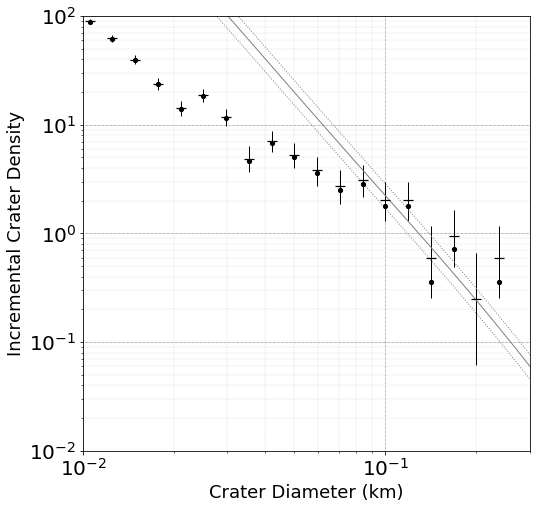

In [274]:
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
d = np.logspace(-2,0)
ax.plot(d,ncf(med)/ncf(1)*npf_new_incremental_left(d,bin_width_exponent=0.25),'gray')
ax.plot(d,ncf(low)/ncf(1)*npf_new_incremental_left(d,bin_width_exponent=0.25),'gray',linestyle=':')
ax.plot(d,ncf(high)/ncf(1)*npf_new_incremental_left(d,bin_width_exponent=0.25),'gray',linestyle=':')
plot_incremental(ds,area,ax=ax,bin_width_exponent=bin_width_exponent,reference_point=0.1)
plt.xlim(0.01,0.3)
plt.ylim(10**-2,10**2)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_incremental_left_fitted.pdf',bbox_inches='tight')

The fit superimposed on the unbinned cumulative plot.

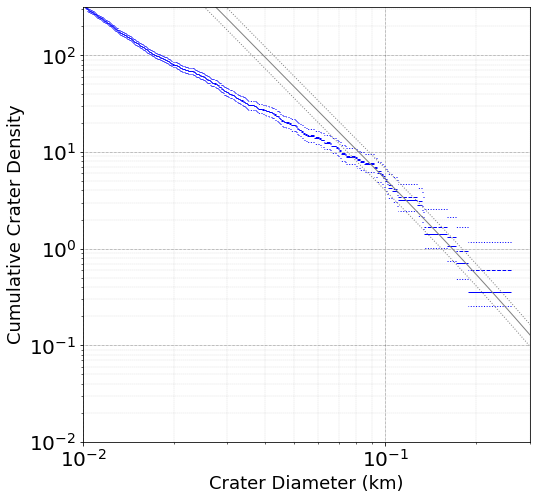

In [276]:
plot_cumulative_unbinned(ds,area,color='blue')
d = np.logspace(-2,0)
plt.plot(d,ncf(med)/ncf(1)*npf_new(d),'gray')
plt.plot(d,ncf(low)/ncf(1)*npf_new(d),'gray',linestyle=':')
plt.plot(d,ncf(high)/ncf(1)*npf_new(d),'gray',linestyle=':')
plt.xlim(0.01,0.3)
plt.ylim(10**-2,10**2.5)
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_cumulative_fitted.pdf',bbox_inches='tight')

Finally, we can examine how the age calculation is affected by diameter measurement error.  Humans never perfectly measure a crater diameter, and there is a small amount of variability between different counters and techniques.  In general, Robbins et al. (2014) found that this error can be broadly modeled as normally distributed with a standard deviation of 10%.  The cratrcountr code provides two mechanisms for dealing with error, depending on whether the errors are random and uncorrelated or systematic and correlated with each other.  Mathematically, we use a kernel approach, following Robbins et al. (2018).  See example plotting notebook for details.

If the errors are random, we can calculated it by applying a standard deviation of 10% to the age calculation function by setting random_sigma=0.1.  Interestingly, assuming random error leads to a slightly higher age, largely because of the nonlinear nature of the lunar production function.

1.4070857050120014 1.8476709957819895 2.3711858167711566 1.7652338021438543
1.47318886791065 1.9236072406424487 2.4562755634398346 1.8384542630222453
Run time: 1.03187s


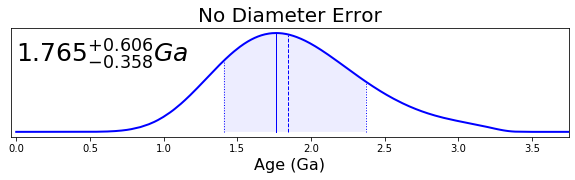

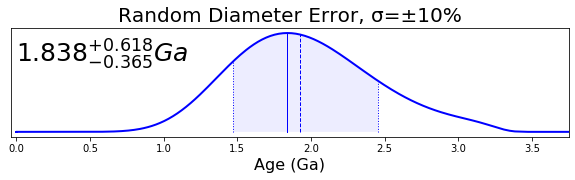

In [643]:
t1=time.time()
low,med,high,max_val=plot_age(ds, area, bin_width_exponent=bin_width_exponent, \
                              saturation_cutoff=saturation_cutoff,random_sigma=0)
plt.title('No Diameter Error',size=20)
print(low,med,high,max_val)
low,med,high,max_val=plot_age(ds, area, bin_width_exponent=bin_width_exponent, \
                              saturation_cutoff=saturation_cutoff,random_sigma=0.1)
print(low,med,high,max_val)
plt.title('Random Diameter Error, σ=±10%',size=20)
t2=time.time()
print('Run time: ' + str(round(t2-t1,5)) + 's')
pfig=plt.gcf()
pfig.savefig('../figs/M146959973L_final_age_random_error.pdf',bbox_inches='tight')

To address systematic error, we simply perturb the diameters of each crater systematically many times (the n_points_systematic variable sets the number of times), run the age calculation, and add together the resulting PDFs.  When run for enough times, it will produce stable results.  Running for 1000 times will produce fairly reasonable results.  Systematic error causes a larger bias than random error.  With systematic error, the median value increases, the maximum likelihood value decreases, and the error range increases considerably.  Because of how much larger the error range becomes, how much wider the PDF becomes, systematic error is a more serious problem than random error.

1.2915376440150068 1.9030625819586073 2.7000611770081355 1.7082025706517094
12.560128688812256


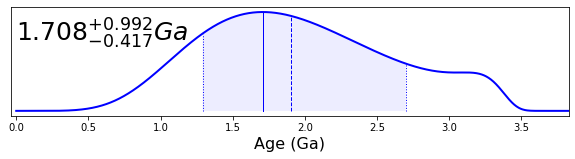

In [644]:
t1=time.time()
low,med,high,max_val=plot_age_systematic_error(ds,area,bin_width_exponent=bin_width_exponent,\
                saturation_cutoff=0.1,n_points=2000,systematic_sigma=0.1, n_points_systematic=1000)
print(low,med,high,max_val)
t2=time.time()
print(t2-t1)